In [1]:
import h5py                                    # Needed for data read-in
import numpy as np
import matplotlib.pyplot as plt
import prysm
from prysm.interferogram import Interferogram  # Needed for data read-in
from prysm import io                           # Needed for data read-in
import os

from tqdm.notebook import tqdm
import jax
import jax.numpy as jnp
from jax import vmap, pmap, jit, grad
from jax.config import config
config.update("jax_enable_x64", True)

import morphine
import morphine_model
import pysynphot as S

import scipy
import scipy.ndimage as ndimage
from scipy.ndimage import zoom

In [2]:
#############################
# Simulated Detector Params #
#############################
pscale = 0.156
num_pix = 2000
pdiam2 = 0.13
osamp = 2

/suphys/cdea7424/.conda/envs/main/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


Interferogram with:
Size: (32.953x32.953)mm
382.368 PV, 35.594 RMS nm


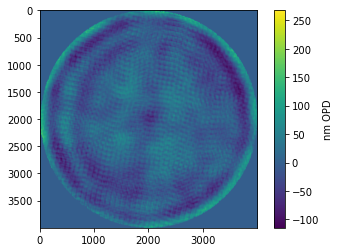

In [3]:
# Reads in data as a dictionary and gets the phase difference - and removes NaNs
secondaryMirror = prysm.io.read_zygo_datx('Secondary midspatials example.datx')
phaseMap = secondaryMirror['phase']
phaseMap = np.nan_to_num(phaseMap)

# converts to a jax array object
phaseMap = jnp.array(phaseMap)

#scales phaseMap
size     = osamp*num_pix
size_in  = phaseMap.shape[0]
ratio    = float(size/size_in)
phaseMap = zoom(phaseMap, ratio, order=0)

plt.imshow(phaseMap)
plt.colorbar(label = 'nm OPD')

# gets info
info = Interferogram.from_zygo_dat('Secondary midspatials example.datx')
print(info)

In [4]:
##################
# Define TOLIMAN #
# wavelength and #
# spectra info   #
##################

n_wavs = 200
central_wav = 550e-9 # m
width = 115e-9 # m
wavs = jnp.linspace(central_wav-width/1.6,central_wav+width/1.6,num=n_wavs) # Go a bit past the edges

filter_n,filter_sigma = 8,105e-9 
central_wav = np.random.normal(scale=0e-11,loc=550e-9)
bandpass = morphine_model.supergaussian(wavs,central_wav,sigma=filter_sigma,n=filter_n)

primary_teff_A = 5790   #temp
primary_z_A = 0.2       #metallicity    - numbers from wikipedia for alpha cen A
primary_logg_A = 4.3    #gravity
acenA = S.Icat('phoenix',primary_teff_A,primary_z_A,primary_logg_A)
specA = acenA.sample(wavs*1e10)
specA /= jnp.max(specA*bandpass)
weights_A = specA*bandpass

In [5]:
#############################
# Stuff to get the optical  #
# system to work            #
#############################

def get_aperture(size, radius=None):
    """
    Produces an array to be used to represent the magnitude of light at the aperture of a telescope.
    Ie an array of zeros with a circle of ones at the centre
    Parameters:
        size: The size of the array to return
        radius (optional): The radius which defines the boundary of the aperture, if left as None it
        will extend the aperture to the edged of the array (ie radius = size/2)
    Returns:
        aperture: An array of zeros with a circular section in the middle of ones
    """
    c = size/2
    xs = jnp.linspace(-c, c, size, endpoint=False)
    Xs, Ys = jnp.meshgrid(xs, xs)
    Rs = jnp.hypot(Xs, Ys)
    
    if radius is None:
        aperture = jnp.where(Rs > c, 0, jnp.ones([size, size]))
    else:
        aperture = jnp.where(Rs > radius, 0, jnp.ones([size, size]))
    return aperture

def get_toliman_pupil(size, file = 'Toliman_pupil.npy',path=None):
    """
    Loads in the Toliman pupil file and returns a scaled version of dimension 'size'. 
    The pupil is returned as a complex array.
    Parameters:
        size: The size of the final output array
        path (optional): The path to the "Toliman_pupil.npy" file. If left as None it will
        look for the file in the current working directory
    Returns:
        toliman_pupil_scaled: A scaled version of the Toliman pupil returned as a complex array
    """
    if path is None:
        toliman_pupil = jnp.load(file)
    else:
        toliman_pupil = jnp.load("{}/Toliman_pupil.npy".format(path))
        
    phase = jnp.angle(toliman_pupil)
    size_in = phase.shape[0]
    ratio = float(size/size_in)
    phase_scaled = zoom(phase, ratio, order=0)
    toliman_pupil_out = get_aperture(size) * jnp.exp(1j * phase_scaled)
    return toliman_pupil_out

In [6]:
############################
# Create aperture elements #
############################
toliman_Sidelobes = morphine_model.TolimanAperture(add_grating=True,grating_fact=0.0003,
                    telescope_diam=0.13, central_wav=central_wav,achromatic_pupil = True,
                    grating_amp=jnp.sqrt(0.1), pupil_file = 'Toliman_pupil.npy')

# toliman_Sidelobes = morphine_model.TolimanAperture(add_grating=True,grating_fact=0.0003,
#                     telescope_diam=0.13, central_wav=central_wav,achromatic_pupil = True,
#                     grating_amp=0, pupil_file = 'SecondaryMirror.npy') # difference is here


pupil = get_toliman_pupil(osamp*num_pix)
#pupilMirror = get_toliman_pupil(osamp*num_pix, file = 'SecondaryMirror.npy')


<class 'jax.interpreters.xla.DeviceArray'>
(4000, 4000)


Text(0.5, 1.0, 'TOLIMAN pupil with secondary mirror effects')

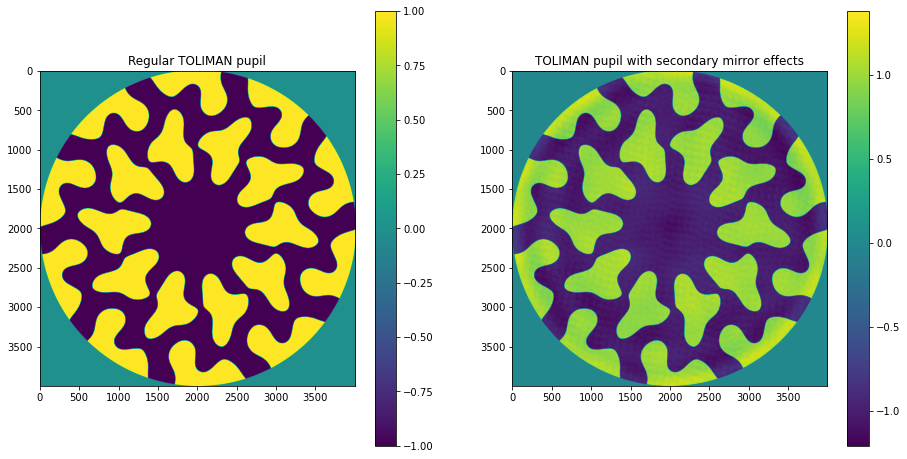

In [7]:
print(type(pupil))
print(jnp.shape(pupil))

plt.figure(figsize = (24,8))

plt.subplot(1,3,1)
plt.imshow(jnp.real(pupil))
plt.colorbar()
plt.title("Regular TOLIMAN pupil")

plt.subplot(1,3,2)
plt.imshow(jnp.real(pupil+phaseMap/550))
plt.colorbar()
plt.title("TOLIMAN pupil with secondary mirror effects")

In [8]:
# creates pseudo pupils. NEEDS to have folder already exist

for i in tqdm(range(len(wavs))):
    Angstrom = '{:.0f}'.format(wavs[i]*1e10)
    alreadyExists = os.path.isfile('pseudoPupils/pseudoPupil{}.npy'.format(Angstrom))
    if alreadyExists == False:
        pseudoPupil = pupil+phaseMap/wavs[i]
        np.save('pseudoPupils/pseudoPupil{}'.format(Angstrom), pseudoPupil)

    

  0%|          | 0/200 [00:00<?, ?it/s]

In [9]:
def get_psf(r, theta, osys, wl):
    osys.source_offset_r = r # arcseconds
    osys.source_offset_theta = theta # degrees
    psf = osys.propagate_mono(wl)[0].intensity
    return psf/np.sum(psf)
get_psf_vmap = vmap(get_psf, in_axes=(None, None, None, 0))


def get_bb_psf(r, theta, osys, wavels, weights, sigma=0):
    psf_stack = get_psf_vmap(r, theta, osys, wavels)
    psf_stack *= weights.reshape([len(weights), 1, 1])
    psf = jnp.sum(psf_stack, axis=0)
    return psf/jnp.sum(psf)


In [20]:
pseudo_image = np.zeros((2000,2000))
pseudo_image = jnp.asarray(pseudo_image)

for i in tqdm(range(len(wavs))):
    # load pupil
    Angstrom = '{:.0f}'.format(wavs[i]*1e10)
    pupil = 'pseudoPupil{}.npy'.format(Angstrom)
    
    toliman_pseudoPupil = morphine_model.TolimanAperture(add_grating=True, grating_fact=0.0003,
                          telescope_diam=0.13, central_wav=central_wav,achromatic_pupil = True,
                          grating_amp=jnp.sqrt(0.1), pupil_file = 'pseudoPupil550.npy')
    
    # create wavelength dependant optical system
    optical_system = morphine.OpticalSystem(npix = num_pix)
    optical_system.add_pupil(toliman_pseudoPupil)
    optical_system.pupil_diameter = pdiam2 
    wf = optical_system.input_wavefront()
    optical_system.add_detector(pixelscale=pscale, fov_arcsec=pscale*num_pix/2) 
    
    # create image
    wav_image = get_psf(0,0, optical_system, wavs[i])
    pseudo_image += wav_image*weights_A[i]
    
pseudo_image /= jnp.sum(pseudo_image)

np.save('Images/WithSecondMirrorEffects', pseudo_image)

  0%|          | 0/200 [00:00<?, ?it/s]

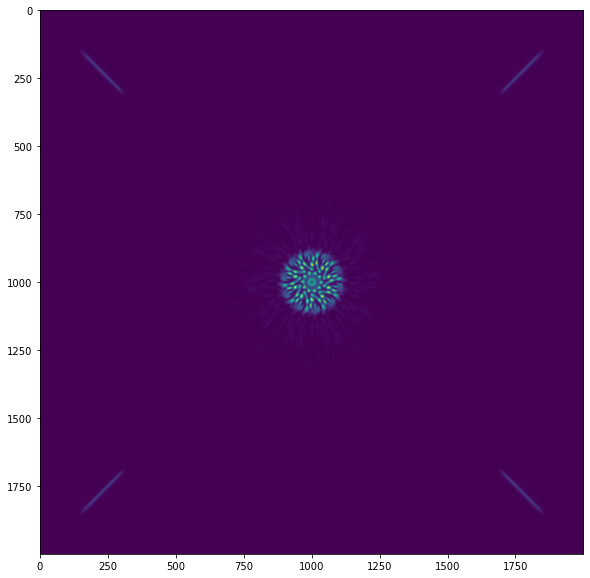

In [21]:
plt.figure(figsize = (10,10))
plt.imshow(pseudo_image)

In [12]:
opsys2 = morphine.OpticalSystem(npix = num_pix)
opsys2.add_pupil(toliman_Sidelobes)
opsys2.pupil_diamter = pdiam2
wf = opsys2.input_wavefront()
opsys2.add_detector(pixelscale=pscale, fov_arcsec=pscale*num_pix/2)

In [13]:
regular_image = get_bb_psf(0,0,opsys2,wavs, weights = weights_A)

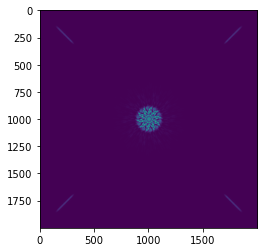

In [15]:
np.save('Images/RegularImage',regular_image)
plt.imshow(regular_image)

0.9999999999999998


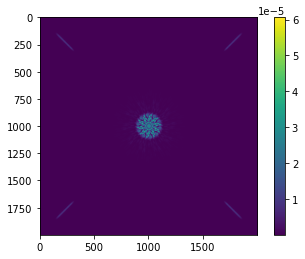

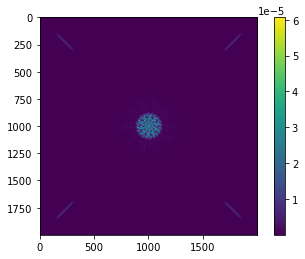

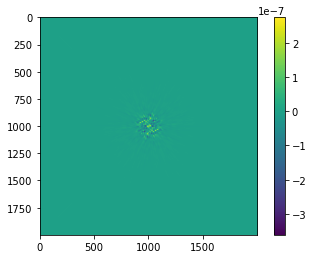

In [2]:
pseudo_image = np.load('Images/WithSecondMirrorEffects.npy')
regular_image = np.load('Images/RegularImage.npy')

plt.figure()
plt.imshow(pseudo_image)
plt.colorbar()

plt.figure()
plt.imshow(regular_image)
print(np.sum(regular_image))
plt.colorbar()

plt.figure()
plt.imshow(pseudo_image - regular_image)
plt.colorbar()

Text(0.5, 1.0, 'Relative residual')

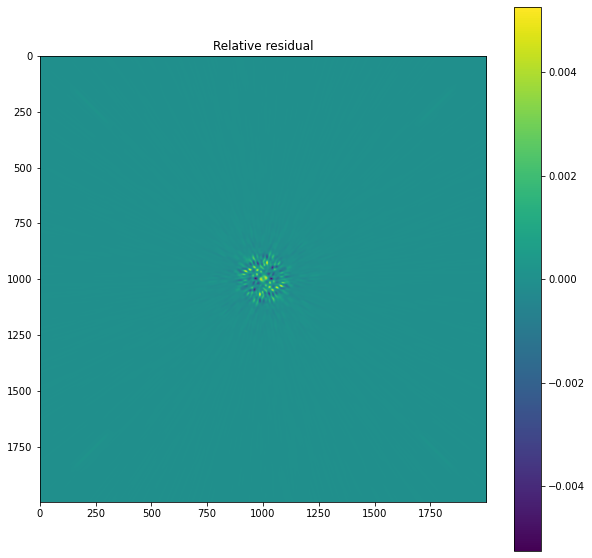

In [3]:
residual = pseudo_image/np.max(pseudo_image) - regular_image/np.max(regular_image)

plt.figure(figsize = (10,10))
plt.imshow(residual)
plt.colorbar()
plt.title('Relative residual')

([], [])

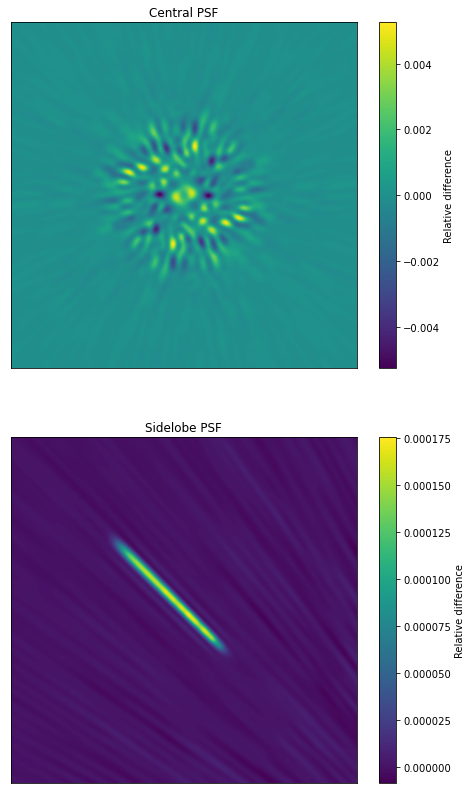

In [12]:
plt.figure(figsize = (8,14))

plt.subplot(2,1,1)
plt.imshow(residual[750:1250, 750:1250])
plt.colorbar(label = 'Relative difference')
plt.title('Central PSF')
plt.xticks([])
plt.yticks([])

plt.subplot(2,1,2)
plt.imshow(residual[0:500, 0:500])
plt.colorbar(label = 'Relative difference')
plt.title('Sidelobe PSF')
plt.xticks([])
plt.yticks([])